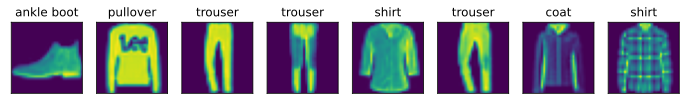

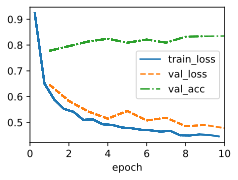

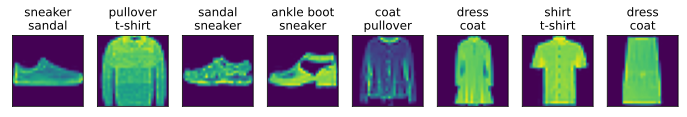

In [3]:
%matplotlib inline
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l
import matplotlib.pyplot as plt

d2l.use_svg_display()


def softmax(X):
    X_exp = torch.exp(X)

    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y]).mean()


class FashionMNIST(d2l.DataModule): 
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(root=self.root, train=False, transform=trans, download=True)

    def text_labels(self, indices):
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,num_workers=self.num_workers)

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)



class Classifier(d2l.Module): 
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions."""

        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).type(Y.dtype)
        compare = (preds == Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare




class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]
    def forward(self, X):
        return softmax(torch.matmul(X.reshape((-1, self.W.shape[0])), self.W) + self.b)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)


data = FashionMNIST(resize=(32, 32))
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)


data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)


In [2]:
pip install d2l==1.0.0a1.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.0 MB/s 
     |████████████████████████████████| 121 kB 45.1 MB/s 
     |████████████████████████████████| 1.6 MB 41.9 MB/s 
     |████████████████████████████████| 83 kB 2.5 MB/s 
